# Depression Detector

Detecting depression in Twitter Tweets

In [1]:
import tensorflow as tf 
device_list =tf.test.gpu_device_name()
device_list


'/device:GPU:0'

In [2]:

!pip install ftfy
!pip install Word2Vec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 959 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for Word2Vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=a9e6fb4dbc616305d88d15669a7ea5d6c45703a27207c0a3dbad72c459545d0f
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built Word2Vec


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
import word2vec
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [50]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 200000 # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 100000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS=20

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kazanova/sentiment140
!unzip sentiment140.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 64% 52.0M/80.9M [00:00<00:00, 285MB/s]
100% 80.9M/80.9M [00:00<00:00, 303MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [14]:
! kaggle datasets download adeneye97/juggernaut-sentiment-analysis-data
! unzip juggernaut-sentiment-analysis-data.zip
DEPRESSIVE_TWEETS_CSV = 'vader_processed_final.csv'
RANDOM_TWEETS_CSV = 'Sentiment Analysis Dataset.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

juggernaut-sentiment-analysis-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  juggernaut-sentiment-analysis-data.zip
  inflating: Sentiment Analysis Dataset.csv  


In [7]:
#RANDOM_TWEETS_CSV.head()

In [8]:
#pd.read_csv('vader_processed_final.csv')

In [15]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, encoding = 'ISO-8859-1',on_bad_lines='skip')
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [16]:
random_tweets_df.columns = random_tweets_df.columns.str.replace('ï»¿ItemID', 'ItemID')
random_tweets_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [17]:
depressive_tweets_df=depressive_tweets_df.drop(columns=['hashtags', 'cashtags'])
depressive_tweets_df.columns = depressive_tweets_df.columns.str.replace('Unnamed: 0', 'ItemID')
depressive_tweets_df.head()

,ItemID,clean_tweet,vader_score,vader_sentiment_label
0,0,"Wow, dad yday: âyou donât take stupid depr...",-0.4122,0
1,1,part really harmfult lot people went every gui...,-0.8074,0
2,2,one ways I got #depression learning dance rain...,0.3382,1
3,3,"see wanna one say PTSD, depression, and/or anx...",-0.4588,0
4,4,IS IT clinical depression palpable hopelessnes...,-0.8316,0


# Preprocessing

Expand contractions, remove links, hashtags, capitalization, and punctuation, deal with negation. Remove links and urls along with whitespaces and stop words. Additionally, stop words beyond the standard NLTK stop words must to be removed to make the model more robust, including days of the week and months.

In [18]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [19]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [20]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [21]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links, then don't append to avoid news articles, etc.
        # Check tweet length, save those > 6 (length of word "lonely")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            #remove hashtags, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            # Remove HTML special entities (e.g. &amp;)
            tweet = re.sub(r'\&\w*;', '', tweet)
            #Convert @username to AT_USER
            tweet = re.sub('@[^\s]+','',tweet)
            # Remove tickers
            tweet = re.sub(r'\$\w*', '', tweet)
            # To lowercase
            tweet = tweet.lower()
            # Remove hyperlinks
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
            # Remove hashtags
            #tweet = re.sub(r'#\w*', '', tweet)
            # Remove Punctuation and split 's, 't, 've with a space for filter
            #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
            # Remove words with 2 or fewer letters
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            # Remove whitespace (including new line characters)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            # Remove single space remaining at the front of the tweet.
            tweet = tweet.lstrip(' ') 
            # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            #expand contraction
            tweet = expandContractions(tweet)
            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            # Tokenize and join to remove unneccessary white spaces
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
            #return (" ".join(words)).strip()

            #stop words
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [22]:
random_tweets_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [23]:
import nltk
nltk.download('stopwords')
#Applying the preprocessing clean_text function to every element in the depressive tweets and random tweets data.
depressive_tweets_arr = [x for x in depressive_tweets_df['clean_tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Visualization with Word Cloud

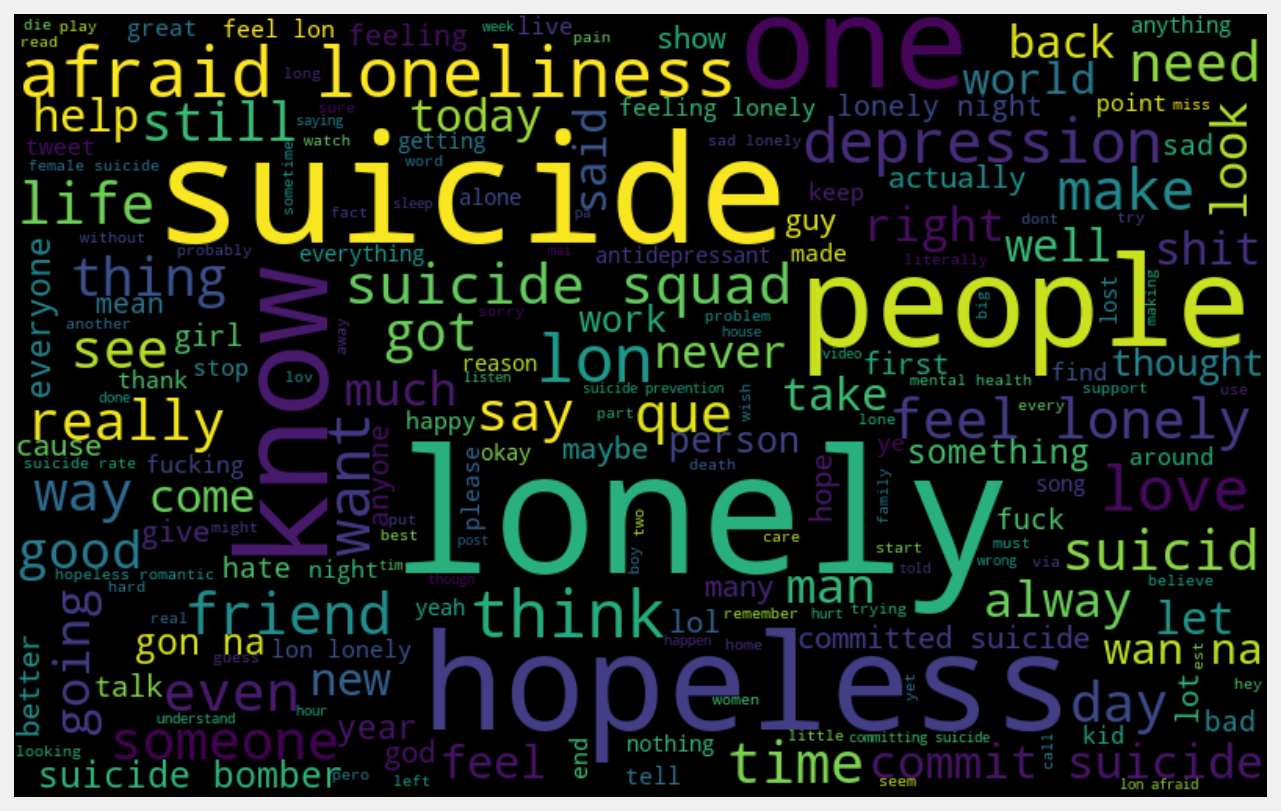

In [24]:
# Depression Tweets
all_words = ' '.join([text for text in X_d])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

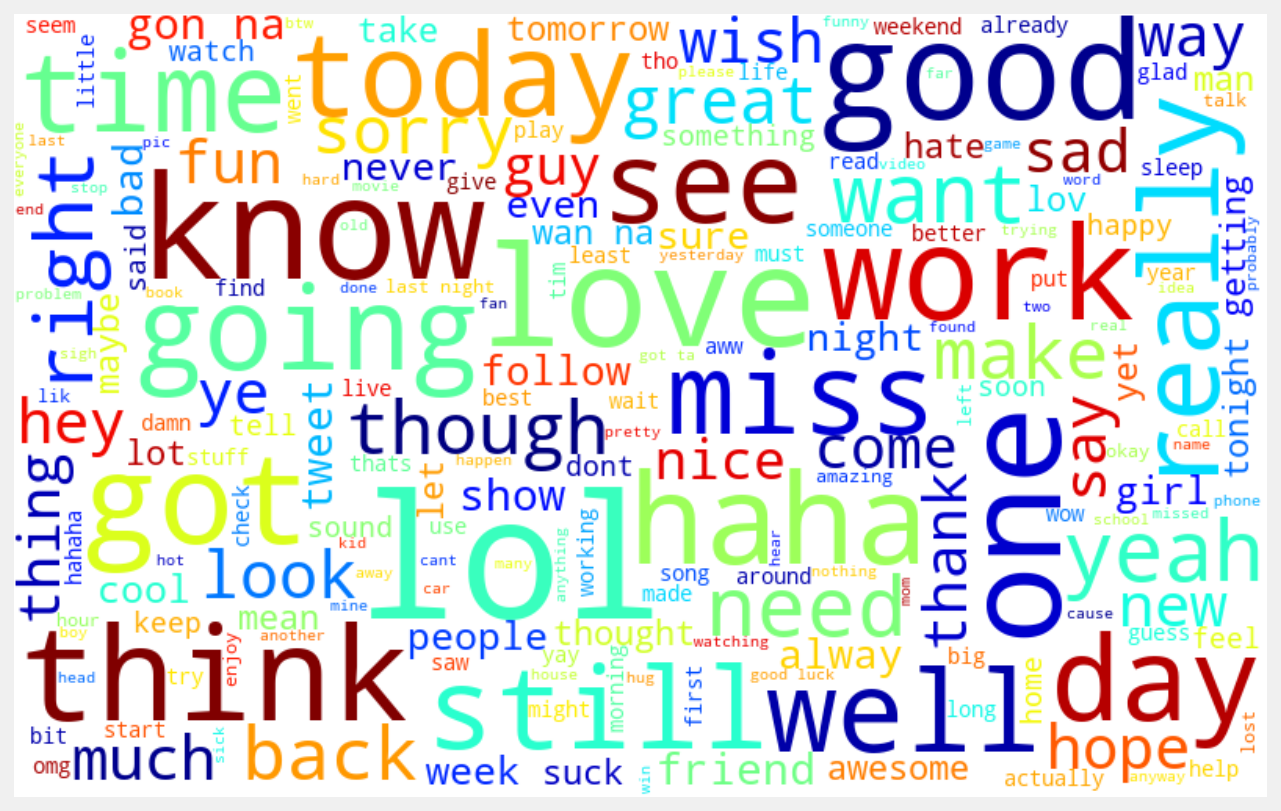

In [25]:
# Random Tweets
all_words = ' '.join([text for text in X_r])
wordcloud = WordCloud(background_color='white', colormap='jet', width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Tokenizer
Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. (The parameter called num_words indicates that we only care about the top 20000 most frequent words.)


In [26]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [27]:
#Applying the tokenizer to depressive tweets and random tweets data.
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)


In [28]:
#Number of unique words in tokenizer.
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 100867 unique tokens


In [29]:
#Pad sequences to the same length.
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (87699, 280)
Shape of data_r tensor: (99832, 280)


# Word2Vec and Embedding
The embedding matrix is an n x m matrix where *n* is the number of words and *m* is the dimension of the embedding. 
We take the minimum between the number of unique words in our tokenizer and max words (in case there are fewer unique words than the max we specified).

In [30]:
! kaggle datasets download leadbest/googlenewsvectorsnegative300

100% 3.17G/3.17G [00:33<00:00, 47.5MB/s]
100% 3.17G/3.17G [00:33<00:00, 103MB/s] 


In [31]:
!unzip googlenewsvectorsnegative300.zip

Archive:  googlenewsvectorsnegative300.zip
  inflating: GoogleNews-vectors-negative300.bin  
  inflating: GoogleNews-vectors-negative300.bin.gz  


In [32]:
# import gensim
# from gensim.models import word2vec
# from gensim.models import KeyedVectors
# from sklearn.metrics.pairwise import cosine_similarity
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE='GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

2022-06-20 07:27:37,597 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2022-06-20 07:28:20,362 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [33]:
#The embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.wv.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)


In [34]:
data_d

array([[    0,     0,     0, ..., 17351,  1554,   375],
       [    0,     0,     0, ...,   873,  6261,   285],
       [    0,     0,     0, ...,  2089,  3540,  9829],
       ...,
       [    0,     0,     0, ...,  3556,     4,  2133],
       [    0,     0,     0, ...,   725, 11030, 19662],
       [    0,     0,     0, ...,   725,   893,   965]], dtype=int32)

# Splitting and labelling the data
Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into test (60%), validation (20%), and train data (20%).
Combine depressive tweets and random tweets arrays and shuffle.

In [ ]:
# print(data_d)
# #len(labels_d)
# print(labels_d.shape)

# print(perm_d.shape)
# print(idx_train_d)
# data_d[idx_train_d]

In [35]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
# arr = np.arange(9).reshape((3, 3))


perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

 # Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

# Building Model (LSTM + CNN)
The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with its embeddings, and then runs the new embedding vector through a convolutional layer. CNNs are well suited for learning spatial structure from data. The convolutional layer takes advantage of this and learns structure from the sequential data which it passes into a standard LSTM layer. The output of the LSTM layer is fed into a Dense model for prediction.


In [36]:
!pip install keras-rnadam 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-rnadam: filename=keras_rnadam-0.2.0-py3-none-any.whl size=4286 sha256=b5c60b6160ed0bd0b4a0661c0b6518aa7080812cb280300210ccb3b58cb866ac
  Stored in directory: /root/.cache/pip/wheels/53/94/15/48466d47bf177439a9a9bb564b06d87f78def05a877da61c67
Successfully built keras-rnadam


In [61]:

from tensorflow.keras.optimizers import Nadam
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)


In [62]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 300)          7500000   
                                                                 
 conv1d_1 (Conv1D)           (None, 280, 32)           28832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 140, 32)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 140, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [63]:
#Training the model
#The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True,
        callbacks=[early_stop]
)

Epoch 1/20
7033/7033 [==============================] - 89s 12ms/step - loss: 0.3451 - acc: 0.8586 - val_loss: 0.2618 - val_acc: 0.9027
Epoch 2/20
7033/7033 [==============================] - 87s 12ms/step - loss: 0.2712 - acc: 0.9011 - val_loss: 0.2460 - val_acc: 0.9092
Epoch 3/20
7033/7033 [==============================] - 86s 12ms/step - loss: 0.2570 - acc: 0.9062 - val_loss: 0.2394 - val_acc: 0.9131
Epoch 4/20
7033/7033 [==============================] - 86s 12ms/step - loss: 0.2494 - acc: 0.9098 - val_loss: 0.2350 - val_acc: 0.9139
Epoch 5/20
7033/7033 [==============================] - 85s 12ms/step - loss: 0.2444 - acc: 0.9117 - val_loss: 0.2329 - val_acc: 0.9151
Epoch 6/20
7033/7033 [==============================] - 85s 12ms/step - loss: 0.2396 - acc: 0.9131 - val_loss: 0.2320 - val_acc: 0.9151
Epoch 7/20
7033/7033 [==============================] - 86s 12ms/step - loss: 0.2369 - acc: 0.9146 - val_loss: 0.2311 - val_acc: 0.9149
Epoch 8/20
7033/7033 [==========================

In [59]:
# #Training the model
# #The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

# hist = model.fit(data_train, labels_train, \
#         validation_data=(data_val, labels_val), \
#         epochs=EPOCHS, batch_size=16, shuffle=True,
#         #callbacks=[early_stop])


SyntaxError: ignored

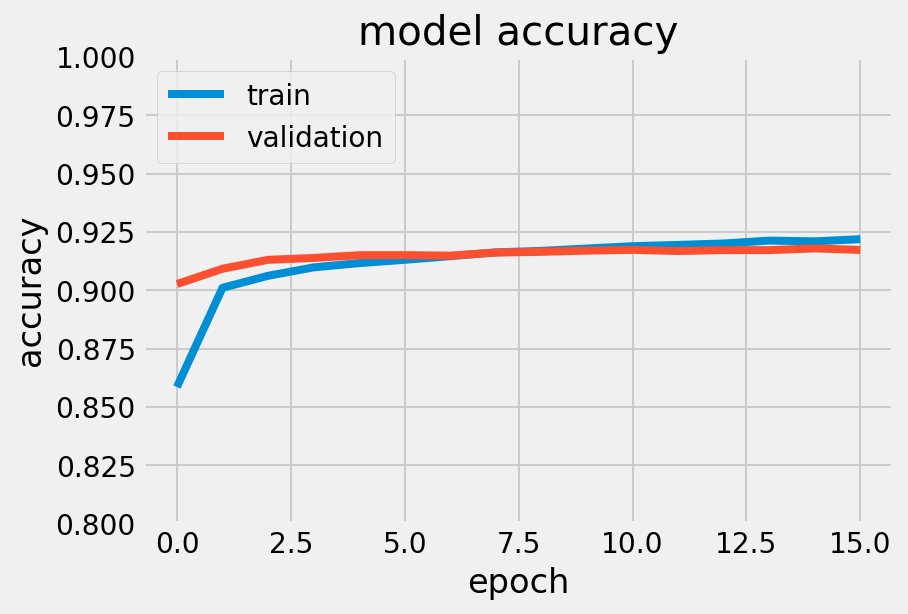

In [64]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.8,1)
plt.show()


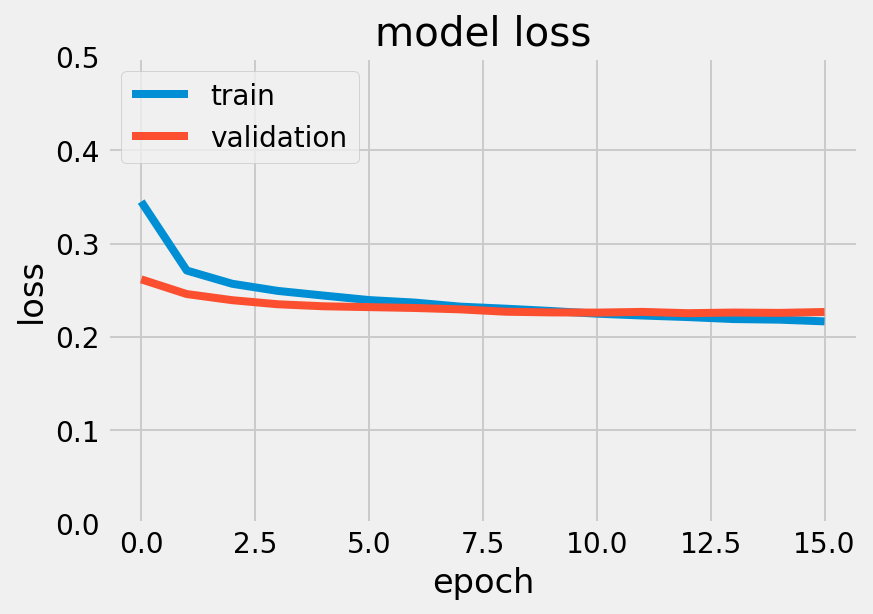

In [65]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.5))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [66]:
#Percentage accuracy of model
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))


Accuracy: 91.88%


In [67]:
#f1, precision, and recall scores
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     19966
           1       0.93      0.89      0.91     17540

    accuracy                           0.92     37506
   macro avg       0.92      0.92      0.92     37506
weighted avg       0.92      0.92      0.92     37506



In [44]:
print('\n# Evaluate')
model.evaluate(data_test, labels_test)


# Evaluate
1173/1173 [==============================] - 7s 6ms/step - loss: 0.2243 - acc: 0.9189


[0.2243097871541977, 0.9188663363456726]

In [45]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [46]:
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

#import h5py


#model.save('detector_model_finalX.pt')
#model.save('detector_model_finalX.h5')
'''
save_model(
    model,
    "keras.h5",
    overwrite=True,
    include_optimizer=True
)

json_string = model.to_json()
yaml_string = model.to_yaml()

#convert to json in terminal
#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/
'''

'\nsave_model(\n    model,\n    "keras.h5",\n    overwrite=True,\n    include_optimizer=True\n)\n\njson_string = model.to_json()\nyaml_string = model.to_yaml()\n\n#convert to json in terminal\n#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/\n'

In [47]:
#Run the code below to save model to json and serialize the weights to HDF5
'''
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model")
'''

'\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model_weights.h5")\nprint("Saved model")\n'

In [48]:
# Run the code below to create pickle
'''
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
'''

"\nimport pickle\n\n# saving\nwith open('tokenizer.pickle', 'wb') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n# loading\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n    \n"

# Comparing the Model to Benchmark
In order to evaluate the effectiveness of the LSTM + CNN model, a logistic regression model is trained with the same train data and the same number of epochs, and tested with the same test data.
### Logistic Regression Base Line Model

In [ ]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [ ]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy


In [ ]:
# Training the logistic regression model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

In [ ]:
# Getting (and comparing) the accuracy of the logistic regression model predicting the test data
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Benchmark Model Accuracy: {:0.3f}'.format(accuracy_logistic))

print("Original Model Accuracy: %.2f%%" % (accuracy*100))